In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import numpy as np
from pylamp.loss.losses import BCELoss,MSELoss
from matplotlib import pyplot as plt
from pylamp.neural.sequential import Sequential
from pylamp.neural.layers import Linear
from pylamp.optim.optimizer import Optim
from pylamp.neural.activations import TanH, Sigmoid
from pylamp.optim.optimizer import SGD
from pylamp.utils.usps import load_usps, show_usps
from pylamp.utils.plotter import Display

In [32]:
def plot_loss(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses, label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Loading Data

In [33]:
uspsdatatrain = "./data/USPS/USPS_train.txt"
uspsdatatest = "./data/USPS/USPS_test.txt"
X_train, y_train = load_usps(uspsdatatrain)
X_test, y_test = load_usps(uspsdatatest)

def normalize_data(X, mean=None, std=None):
    if mean is None:
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
    return X - mean / std, mean, std

X_train, mean, std = normalize_data(X_train)
X_test, _, _ = normalize_data(X_test, mean, std)

## Autoencoder on USPS data

• Encodage : Linear(256,100) → TanH() → Linear(100,10) → TanH()

• Décodage : Linear(10,100) → TanH() → Linear(100,256) → Sigmoide()

### One big Sequential

In [34]:
autoencoder = Sequential()
autoencoder.add_module(Linear(256,100))
autoencoder.add_module(TanH())
autoencoder.add_module(Linear(100,10))
autoencoder.add_module(TanH())
autoencoder.add_module(Linear(10,100))
autoencoder.add_module(TanH())
autoencoder.add_module(Linear(100,256))
autoencoder.add_module(Sigmoid())


loss = BCELoss()
optimizer_autoencoder = Optim(autoencoder,loss,1e-3)
autoencoder_losses = SGD(optimizer_autoencoder,X_train, X_train, batch_size=256,epochs=300,verbose=True)

Epoch 1/300, Average Loss: 3.256002957791492
Epoch 31/300, Average Loss: -1.9321596725877037
Epoch 61/300, Average Loss: -3.409009702838476
Epoch 91/300, Average Loss: -4.112416451815952
Epoch 121/300, Average Loss: -4.5555880076972874
Epoch 151/300, Average Loss: -4.86553755194206
Epoch 181/300, Average Loss: -5.109509240227218
Epoch 211/300, Average Loss: -5.290671249510503
Epoch 241/300, Average Loss: -5.438619479064656
Epoch 271/300, Average Loss: -5.55712235463539
Training finished.


In [35]:
X_test.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
testing = np.array([X_test[40]])
testing_pred = autoencoder.forward(testing)
print("Original VS AutoEncoder output:")
Display.compare_images(testing,testing_pred,shape=(16,16),fig_size=(10,5))

IndexError: tuple index out of range

### Seperating encoder and decoder into two sequentials and MSELoss

In [ ]:
autoencoder = Sequential()

encoder = Sequential()
encoder.add_module(Linear(256,100))
encoder.add_module(TanH())
encoder.add_module(Linear(100,10))
encoder.add_module(TanH())

decoder = Sequential()
decoder.add_module(Linear(10,100))
decoder.add_module(TanH())
decoder.add_module(Linear(100,256))
decoder.add_module(Sigmoid())

autoencoder.add_module(encoder)
autoencoder.add_module(decoder)

loss = MSELoss()
optimizer_autoencoder = Optim(autoencoder,loss,1e-3)
autoencoder_losses = SGD(optimizer_autoencoder,X_train, X_train, batch_size=256,epochs=300,verbose=True)

Epoch 1/300, Average Loss: 0.45030907414989674
Epoch 31/300, Average Loss: 0.29394627606905316
Epoch 61/300, Average Loss: 0.26526574075956916
Epoch 91/300, Average Loss: 0.24313242404345664
Epoch 121/300, Average Loss: 0.23242547940110136
Epoch 151/300, Average Loss: 0.2298463620565527
Epoch 181/300, Average Loss: 0.22970909608530818
Epoch 211/300, Average Loss: 0.229648460392451
Epoch 241/300, Average Loss: 0.22961160191973326
Epoch 271/300, Average Loss: 0.22958667533369764
Training finished.


encoded=array([[-0.99999619, -0.99999994,  0.99799173,  1.        , -0.98453447,
        -0.99964608, -0.99999997, -0.99990964, -0.9999998 , -0.99999934]])
Original VS AutoEncoder output:


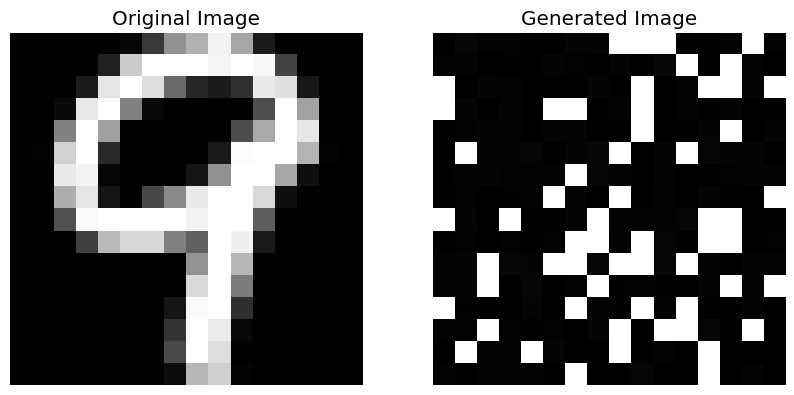

In [ ]:
testing = np.array([X_test[0]])
encoded = encoder.forward(testing)
print(f"{encoded=}")
decoded = decoder.forward(encoded)
print("Original VS AutoEncoder output:")
Display.compare_images(testing,decoded,shape=(16,16),fig_size=(10,5))